In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import shutil, os, random, gc, time
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras import backend as K

from keras.applications import InceptionV3, VGG16, ResNet50

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.losses import binary_crossentropy

import cache_magic
%matplotlib inline

In [2]:
DATA_PATH = './data/'
MODEL_PATH = './model'

# DeepFashion: Versión reducida

In [ ]:
# Constantes

# Rutas a directorios de datos
ANNO_FINE_PATH = DATA_PATH + 'anno_fine'
TRAIN_PATH = ANNO_FINE_PATH + '/train'
VALIDATION_PATH = ANNO_FINE_PATH + '/val'
TEST_PATH = ANNO_FINE_PATH + '/test'
AUGMENTED_DATA_PATH = ANNO_FINE_PATH + '/augmented'
IMG = DATA_PATH + 'img'

# Rutas a ficheros de datos
ATTR_CLOTH_LIST_FILE = ANNO_FINE_PATH + '/list_attr_cloth.txt'
ATTR_IMG_LIST_FILE = ANNO_FINE_PATH + '/list_attr_img.txt'

# Constantes relativas al conjunto de datos
ATTR_TYPES = {'1':"Estampado",'2':"Tipo de manga",'3':"Forma",'4':"Tipo de cuello",'5':"Tejido",'6':"Tallaje"}
NUM_CLASSES = 26 


## 1. Lectura y preprocesado de datos

In [4]:
# Lectura de la lista de atributos (fichero list_attr_cloth.txt)
def read_attr_cloth_list():
    column_to_attr_name = {}
    attr_type_to_columns = {}
    
    with open(ATTR_CLOTH_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de etiquetas
        fp.readline() # Ignorar cabecera
        column = 0
        for line in fp: 
            fields = line.split()
            attr = fields[0]
            attr_type = fields[1]
            column_to_attr_name[column] = attr
            if attr_type in attr_type_to_columns:
                attr_type_to_columns[attr_type].append(column)
            else:
                attr_type_to_columns[attr_type] = [column]
            column += 1
    return column_to_attr_name, attr_type_to_columns

# Lectura de atributos asociados a una imagen (lectura list_attr_img)
def read_attr_img_list():
    attr_dict = []
    with open(ATTR_IMG_LIST_FILE) as fp: 
        fp.readline() # Ingorar numero de lineas
        fp.readline() # Ignorar cabecera
        for line in fp:
            row = [int(i) for i in line.split()[1:]]
            attr_dict.append(row)
    return pd.DataFrame.from_records(attr_dict)


In [5]:
column_to_attr_name, attr_type_to_columns = read_attr_cloth_list()           
attr_img_list = read_attr_img_list()
attributes = list(column_to_attr_name.values())

In [6]:
def build_iterator_dataframe(partition):
    partition_attribute_filepath = ANNO_FINE_PATH + "/" + partition + "_attr.txt"
    print(partition_attribute_filepath)
    data = pd.read_csv(partition_attribute_filepath, sep = ' ', names = attributes, index_col=False)
    data['filename'] = [str(i) + '.jpg' for i in range(0,len(data))]
    return data

In [7]:
def read_image_list(file):
    file_path = ANNO_FINE_PATH + '/' + file + '.txt'
    with open(file_path) as fp:
        return [DATA_PATH + img.rstrip('\n') for img in fp]
    
def build_partition_data_path(partition):
    return ANNO_FINE_PATH + '/' + partition

def create_data_structure(force=False):
    for partition in ['test', 'train', 'val']:
        partition_data_path = build_partition_data_path(partition)
        
        # Forzar recarga
        if os.path.exists(partition_data_path) and force:
            shutil.rmtree(partition_data_path)
        
        if not os.path.exists(partition_data_path):
            os.mkdir(partition_data_path)
            image_list = read_image_list(partition)
            for i, src in enumerate(image_list):
                dst = partition_data_path + '/' + str(i) + '.jpg' 
                shutil.copyfile(src, dst)


In [8]:
create_data_structure(False)

## 2. Aumentación de datos

A continuación se define la función que crea los generadores de imágenes, que realizan las transformaciones de data augmentation de forma dinámica en cada epoch del entrenamiento de los modelos. Se han configurado de forma que las imagenes generadas se almacenen en el directorio definidos por la constante AUGMENTED_DATA_PATH para poder ser inspeccionados. 

La función es parametrizable para poder realizar un análisis de los valores óptimos y elegir los más adecuados para esta tarea de clasificación. Este análisis se realiza más adelante.

In [9]:
SEED = 1
BATCH_SIZE = 4

# Construcción del generador de datos de entrenamiento
def build_train_datagen(shear_range=0.025, zoom_range=0.025, rotation_range=2.5, fill_mode='nearest'):
    return ImageDataGenerator(
        rescale=1/255.0,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        fill_mode = fill_mode,
        horizontal_flip=True)

# Construcción de los generadores de datos de entrenamiento y validación
def build_generators(img_size, shear_range, zoom_range, rotation_range, fill_mode):
        
    # Borrar los directorios con las imagenes generadas
    if os.path.exists(AUGMENTED_DATA_PATH):
        shutil.rmtree(AUGMENTED_DATA_PATH)
    os.mkdir(AUGMENTED_DATA_PATH)
    
    # Generator de entrenamiento
    train_datagen = build_train_datagen(shear_range, zoom_range, rotation_range, fill_mode)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = build_iterator_dataframe('train'),
        x_col="filename",
        y_col=attributes,
        directory=TRAIN_PATH,
        target_size=(img_size,img_size),
        batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED,
        save_to_dir=AUGMENTED_DATA_PATH
    )
    
    print(TRAIN_PATH)

    # Generator de validación
    validation_datagen = ImageDataGenerator(
         rescale=1./255
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('val'),
        x_col="filename",
        y_col=attributes,
        directory=VALIDATION_PATH,
        target_size=(img_size,img_size),
        #batch_size=BATCH_SIZE,
        class_mode='raw',
        color_mode='rgb',
        seed=SEED
    )
    
    return train_generator, validation_generator


# Construcción del generador de datos de test
def build_test_generator(img_size=224):
        
    test_datagen = ImageDataGenerator(
         rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=build_iterator_dataframe('test'),
        x_col="filename",
        y_col=attributes,        
        directory=TEST_PATH,
        target_size=(img_size,img_size),
       # batch_size=BATCH_SIZE,
        class_mode=None,
        color_mode='rgb',
        seed=SEED,
        shuffle=False
    )
    
    return test_generator 

### 2.1 Ejemplo de datos generados

El siguiente código elige de forma aleatoria una imagen de la partición de test, y muestra 9 imagenes alteradas generadas con el código definido anteriormente. 

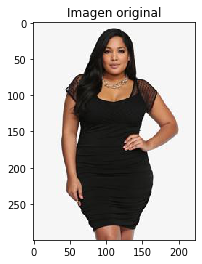

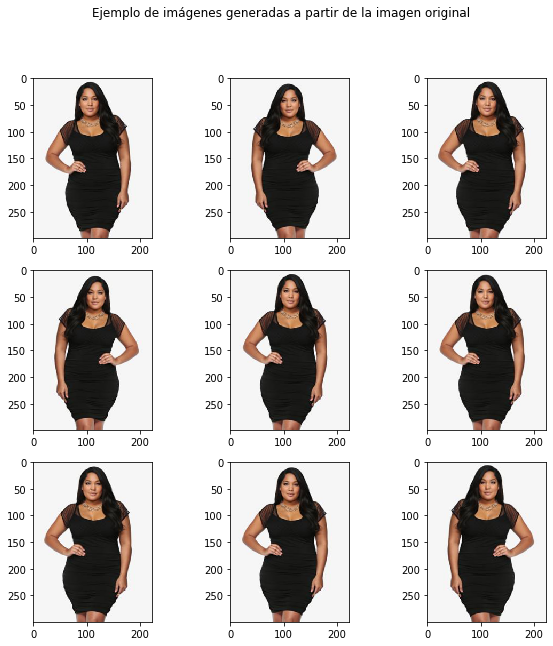

In [10]:
# Carga de una imagen aleatoria
path = ANNO_FINE_PATH + '/test'
file = random.choice(os.listdir(path))
img = load_img('{}/{}'.format(path, file))

plt.title('Imagen original')
plt.imshow(img)
plt.show()

# Preprocesado y preparación del iterador
data = img_to_array(img)
samples = np.expand_dims(data, 0)

generator = build_train_datagen()
it = generator.flow(samples, batch_size=1)

# Generación de 9 imágenes a partir de la imagen original
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle('Ejemplo de imágenes generadas a partir de la imagen original')
for x in range(9):
    batch = it.next()
    axs[x//3,x%3].imshow(batch[0], cmap='gray')
plt.show()

## 3. Automatización

Para poder probar distintos modelos de forma simple se define una función **_train_** que encapsula todo el código necesario para realizar el entrenamiento (limpieza de sesiones anteriores, instanciación del modelo y generadores de datos, etc...) 

Cabe destacar que se llama a la función fit con tres callbacks:
- Checkpoint, para persistir el modelo que minimiza el loss y poder ser empleado más adelante, en los casos en los que un modelo empiece a sobreajustar a los datos de entrenamiento. 
- Reducción de learning rate en el caso de que en N iteraciones seguidas el modelo no mejore. Viene definido por la constante LR_REDUCTION_PATIENCE. 
- Early stopping, para realizar la parada del entrenamiento en el caso de que no se consiga una mejora ni reduciendo la velocidad de aprendizaje. Viene definido por la constante EARLY_STOPPING_PATIENCE. 

Nótese que la función **_train_** requiere de dos parámetros obligatorios: model_name y model_id. Es primero es necesario porque, para realizar la instanciación del modelo se realiza una llamada una función con nombre **_build\_{model\_name}_**. El segundo parámetro es empleado a la hora de generar el nombre con el que persiste un modelo (**_model\_name\_model\_id.h5}_**) para poder persistir distintas versiones de un mismo tipo de modelo.

Esto permite que el código sea genérico y baste con definir una función **_build\_{model\_name}_** para poder entrenar y validar un modelo nuevo. 


In [39]:
EARLY_STOPPING_PATIENCE = 8
LR_REDUCTION_PATIENCE = 4

# Conversión del tamaño de la imagen al shape esperado como input del modelo
def to_input_shape(img_size):
    return (img_size,img_size,3)

# Construcción del path donde se persiste el modelo
def to_model_path(model_name, model_id):
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)
    return '{}/{}_{}.h5'.format(MODEL_PATH, model_name, model_id)

# Construcción del nombre de la función de instanciación de un modelo
def to_build_function(model_name):
    return 'build_' + model_name

# Desactiva el entrenamiento del X% de capas iniciales. 
def freeze_layers(model, ratio=0.5):
    n_layers = len(model.layers)
    last_layer_to_freeze = int(n_layers*ratio)
    
    for layer in model.layers[:last_layer_to_freeze]:
        layer.trainable = False
    for layer in model.layers[last_layer_to_freeze:]:
        layer.trainable = True
    
    return model


def build_callbacks(model_name, model_id, store_model):
    callbacks = []
    # Parar la ejecución si el loss no disminuye en 3 iteraciones
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, verbose=1, min_delta=1e-4)
    callbacks.append(early_stopping)
    # Reducir el learning rate si el loss no disminuye en 3 iteraciones
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_REDUCTION_PATIENCE, verbose=1, min_delta=1e-4)  
    callbacks.append(reduce_lr)
    # Guardar el modelo que más disminuye el loss en fichero
    if store_model:
        checkpoint = ModelCheckpoint(filepath = to_model_path(model_name, model_id), 
                                     monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks.append(checkpoint)
    return callbacks

# Entrenamiento, y todo el pre-procesamiento necesario. 
def train(model_name,
          model_id=None,
          max_epochs=100, 
          img_size=224,
          shear_range=0.05, 
          zoom_range=0.150, 
          rotation_range=2.5, 
          fill_mode='constant',
          store_model=True,
          two_step_fit=False,
          freeze_layers_ratio=None,
          model_build_params=None,
          loss_function=weighted_binary_crossentropy
         ):
    
    # Forzar limpieza y pasar el GC
    K.clear_session()
    #cuda.select_device(0)
    #cuda.close()
    gc.collect()
    
    # Instanciación del modelo. Todos los métodos siguen el patrón "build_xxx", donde xxx es esl nombre del modelo
    input_shape = to_input_shape(img_size)
    model = globals()[to_build_function(model_name)](input_shape, model_build_params)
    #model.summary()
    
    # COMPILE con run options para debug en caso de oom
    #run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
    
    # Instanciación de los generators de datos
    train_generator, validation_generator = build_generators(img_size, shear_range, 
                                                             zoom_range, rotation_range, fill_mode)
    
    
    
    # FIT
    # Dependiendo de la complejidad del modelo, se hace fit una única vez, o dos veces para ajustar primero las últimas capas
    # y posteriormente el resto
    if two_step_fit:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, False),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
        # Segunda fase de training para entrenar el resto de las capas
        model = freeze_layers(model, freeze_layers_ratio)
        model.compile(optimizer='adam', loss=loss_function, metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    else:
        h = model.fit_generator(train_generator, validation_data=validation_generator, 
                                epochs=max_epochs, callbacks = build_callbacks(model_name, model_id, store_model),
                                steps_per_epoch=50,
                                validation_steps=10
                               )
    
    return (h.history['val_loss'], h.history['val_top_k_categorical_accuracy'])

In [11]:
# VISUALIZACIÓN DE MÉTRICAS PARA COMPARAR MODELOS
# results = dict k -> (val_loss, val_acc)
def plot(results, metric, legend_loc = 'upper right'):
    legend = []
    fig = plt.figure(figsize=(15,10))
    for k,v in results.items():
        ix = 0 if metric == 'val_loss' else 1
        plt.plot(v[ix])
        legend.append(k)
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(legend, loc=legend_loc)
    figsize=(10,8)
    plt.show()  

## 4. Optimización de hiperparámetros

Para la búsqueda de valores óptimos para distintos parámetros empleados por el proceso se empleará un modelo 'baseline'. Éste se basa en una arquitectura ResNet50 con función de activación sigmoide para permitir la clasificación multietiqueta. 

In [22]:
def build_baseline(a,b):
    base_model = ResNet50(
        include_top=True,
        weights="imagenet",
        input_shape=(224,224,3),
        pooling='max'
        )
    x = base_model.output
    x = Dense(64, activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

### 4.1 Tamaño de la imagen

De momento se obvia la comprobación de si el tamaño de la imagen influye en el resultado de clasificación

### 4.2 Parámetros de data augmentation

Vamos a comprobar como influyen los parámetros de data augmentation sobre el accuracy. Se trata de encontrar valores equilibrados puesto que valores muy bajos pueden causar que el modelo no sea capaz de generalizar correctamente, mientas que con valores muy altos se estén realizando transformaciones muy alejadas de la realidad de los datos. 

In [27]:
N = 25

def evaluate_data_augmentation_params():  
    results = pd.DataFrame(columns = ['shear_range','zoom_range', 'rotation_range', 'fill_mode', 'val_loss','val_top_k_categorical_accuracy'])
    for it in range(0,N):
        shear_range = random.choice([0.025, 0.05, 0.1, 0.15])
        zoom_range = random.choice([0.025, 0.05, 0.1, 0.15])
        rotation_range = random.choice([2.5, 5, 7.5])
        fill_mode = random.choice(["constant", "nearest", "wrap"]) # Ignoramos reflect
        print('Evaluation #{}'.format(it))
        (val_loss, val_top_k_categorical_accuracy) = train('baseline', it, store_model=False,
                                                           shear_range=shear_range, zoom_range=zoom_range, rotation_range=rotation_range,
                                                           fill_mode = fill_mode, img_size=224)
        results.loc[it] = [shear_range, zoom_range, rotation_range, fill_mode, min(val_loss), max(val_top_k_categorical_accuracy)]
    return results

In [29]:
%cache data_augmentation_results = evaluate_data_augmentation_params()
data_augmentation_results.sort_values(by='val_loss', ascending=True).head(n=10)

Loading cached value for variable 'data_augmentation_results'. Time since caching: 9:36:23.820168


,shear_range,zoom_range,rotation_range,fill_mode,val_loss,val_top_k_categorical_accuracy
21,0.050,0.150,2.5,constant,0.347642,0.502992
11,0.050,0.100,5,wrap,0.348438,0.466365
13,0.025,0.050,2.5,wrap,0.348558,0.437539
1,0.100,0.150,2.5,constant,0.349242,0.393575
18,0.100,0.100,7.5,constant,0.349593,0.453258
17,0.100,0.150,7.5,nearest,0.349950,0.479040
7,0.050,0.025,5,nearest,0.350146,0.497988
20,0.100,0.050,7.5,constant,0.350720,0.377487
23,0.100,0.050,5,constant,0.350886,0.477600
24,0.050,0.150,7.5,constant,0.350899,0.520690


### 4.3 Selección de función de loss

En pruebas realizadas con anterioridad se ha comprobado que el accuracy no es una buena métrica para este problema puesto que hasta con el modelo más simple se consiguen valores superiores al 80%. Esto se debe a que esta métrica es el promedio del número etiquetas predicho correctamente dividido entre el número total de etiquetas para cada una de las observaciones. El hecho de que se obtengan valores tan altos se debe a que blablabla. Por ello, se ha reemplazado esta métrica por TopKCategoricalAccuracy.

Por otro lado, se ha hecho una comparativa entre dos funciones de loss que se emplean comunmente para las clasificaciones multietiqueta: binary cross entropy y weighted binary crossentropy. El hecho de que por cada observación existan 20 etiquetas con valor 0 y 6 con valor 1 hace pensar que asignándole un peso superior al valor 1 se conseguirá un resultado mejor. 

Esta última función se encuentra disponible en Tensorflow pero no está adaptada para ser usada directamente desde Keras, por lo que se emplea el código publicado abiertamente en un artículo de [StackExchange](https://stats.stackexchange.com/questions/261128/neural-network-for-multi-label-classification-with-large-number-of-classes-outpu)


In [12]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfb

POS_WEIGHT = 10  # multiplier for positive targets, needs to be tuned

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.math.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

Se entrena el modelo baseline empleando las dos funciones de loss, y se establece la comparativa.

In [35]:
# %cache -r res_binary_crossentropy
%cache res_binary_crossentropy = train('baseline', loss_function=binary_crossentropy)
%cache res_weighed_crossentropy = train('baseline', loss_function=weighted_binary_crossentropy)

Loading cached value for variable 'res_binary_crossentropy'. Time since caching: 0:26:09.813350
Loading cached value for variable 'res_weighed_crossentropy'. Time since caching: 0:19:20.285307


In [38]:
print(min(res_binary_crossentropy[1]))
print(max(res_binary_crossentropy[1]))

print(min(res_weighed_crossentropy[1]))
print(max(res_weighed_crossentropy[1]))

0.025540122762322426
0.43532878160476685
0.44123226404190063
0.483117014169693


Como se puede observar en la métrica anterior, se obtiene un valor superior de accuracy con la versión ponderada. Esta será la función que se empleará para el entrenamiento de los modelos en el siguiente apartado. 

## 5. Entrenamiento

En este apartado se probarán varias arquitecturas de redes pre-entrenadas disponibles con Keras. Estas redes permiten beneficiarse del _transfer learning_ y poder congelar un número de capas iniciales ya pre-entrenadas para detectar las características más abstractas.

Para cada tipo de modelo se realiza un random search para encontrar los valores óptimos de los hiperparámetros. En todos ellos se emplea la sigmoid como función de activación en la capa de salida para poder obtener un valor entre 0 y 1 para todas las etiquetas. 

Se emplea Adam como optimizador para todos los modelos. No se ha hecho una comparativa con otros optimizadores. 

In [40]:
def build_InceptionV3(input_shape, params):
    base_model = InceptionV3(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_ResNet50(input_shape, params):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

def build_VGG16(input_shape, params):
    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=params[GLOBAL_POOLING_TYPE],
        #classes=1000
        )
    freeze_all_layers(base_model)
    
    x = base_model.output
    if not params[GLOBAL_POOLING_TYPE]:
        x = Flatten()(x)
    x = Dense(params[DENSE_LAYER_SIZE_PARAM], activation="relu")(x)
    x = Dense(NUM_CLASSES, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    
    return model


A continuación se define el código para realizar un random search de los parámetros. Se realizará una exploración de N (20) combinaciones por cada arquitectura probada.

In [41]:
KERNEL_SIZE_PARAM = "kernel_size"
DROPOUT_PARAM = "dropout"
GLOBAL_POOLING_TYPE = "global_pooling_type"
DENSE_LAYER_SIZE_PARAM = 'dense_layer_size'
NUM_BLOCKS_PARAM = "num_blocks"
FIRST_CONV_LAYER_SIZE = "first_conv_layer_size"

N = 20

def freeze_all_layers(model):
    for layer in model.layers:
        layer.trainable = False

def try_pretrained_model(model_name):
    results = pd.DataFrame(columns = [GLOBAL_POOLING_TYPE, DENSE_LAYER_SIZE_PARAM, 'freeze_layers_ratio', 'val_loss','val_top_k_categorical_accuracy', 'time'])
    for i in range(0, N):
        try:
            params = {}
            params[GLOBAL_POOLING_TYPE] = random.choice(['avg', 'max', None])
            params[DENSE_LAYER_SIZE_PARAM] = random.randrange(128,513,8)
            freeze_layers_ratio = random.choice([0.5, 0.6, 0.7, 0.8])
            print('Evaluation #{}'.format(i))
            start = time.time()
            (val_loss, val_top_k_categorical_accuracy) = train(model_name, i, store_model=True, two_step_fit=True, 
                                        freeze_layers_ratio=freeze_layers_ratio, model_build_params=params)
            end = time.time() - start
            results.loc[i] = [params[GLOBAL_POOLING_TYPE], params[DENSE_LAYER_SIZE_PARAM], freeze_layers_ratio, val_loss, val_top_k_categorical_accuracy, end]
        except Exception as e:
            print('Error: {}'.format(e))
            print('Error with params: {}'.format(params))
    return results

Lanzamos la búsqueda:

In [46]:
RESET = False
if(RESET):
    %cache -r results_inceptionV3
    %cache -r results_resnet50 
    %cache -r results_vgg16


%cache results_inceptionV3 = try_pretrained_model('InceptionV3')
%cache results_resnet50 = try_pretrained_model('ResNet50')
%cache results_vgg16 = try_pretrained_model('VGG16')

Loading cached value for variable 'results_inceptionV3'. Time since caching: 7:30:18.202031
Loading cached value for variable 'results_resnet50'. Time since caching: 5:36:50.627274
Loading cached value for variable 'results_vgg16'. Time since caching: 3:17:17.857539


Definimos una función para ordenar los modelos generados en función del valor mínimo de loss. El índice de la tabla representa el model_id con el que se ha persistido el modelo, para poder ser recuperado en la fase de evaluación. 

In [61]:
# Ordena todos los modelos en base al máximo accuracy conseguido.  
def sort_by_max_accuracy(df):
    df["min_val_loss"] = df.apply(lambda row: min(row['val_loss']), axis=1)
    df["max_val_top_k_categorical_accuracy"] = df.apply(lambda row: max(row['val_top_k_categorical_accuracy']), axis=1)
    return df.sort_values(by='min_val_loss', ascending=True).head(n=5)

Mostramos los resultados obtenidos para la arquitectura InceptionV3:

In [62]:
sort_by_max_accuracy(results_inceptionV3)

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_loss,val_top_k_categorical_accuracy,time,min_val_loss,max_val_top_k_categorical_accuracy
6,avg,320,0.6,"[2.9742226600646973, 3.454810619354248, 3.0730...","[0.23574380576610565, 0.23801293969154358, 0.2...",784.702089,0.748604,0.522835
11,avg,272,0.7,"[3.456360101699829, 3.384723663330078, 1.76845...","[0.2414686232805252, 0.3212128281593323, 0.371...",452.543839,0.880138,0.482165
2,avg,168,0.5,"[6.837651252746582, 1.7128119468688965, 2.8305...","[0.46244341135025024, 0.45641598105430603, 0.4...",497.801406,0.898355,0.466309
16,avg,232,0.6,"[3.650085926055908, 2.750995397567749, 1.71590...","[0.5021146535873413, 0.47144070267677307, 0.44...",513.944501,0.918768,0.502115
5,max,312,0.7,"[5.194391250610352, 3.2107996940612793, 4.7090...","[0.3786427676677704, 0.30448558926582336, 0.30...",593.825720,0.970010,0.378643


Mostramos los resultados obtenidos para la arquitectura ResNet50:

In [63]:
sort_by_max_accuracy(results_resnet50)

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_loss,val_top_k_categorical_accuracy,time,min_val_loss,max_val_top_k_categorical_accuracy
4,avg,192,0.5,"[2.4690160751342773, 2.7107551097869873, 7.612...","[0.4323893189430237, 0.3474363684654236, 0.341...",412.911637,1.162580,0.432389
2,avg,376,0.5,"[8.43064022064209, 1.872387170791626, 1.507320...","[0.3624406158924103, 0.3789179027080536, 0.320...",348.801829,1.259550,0.390873
1,max,176,0.7,"[9.614396095275879, 7.911287307739258, 9.10595...","[0.5932484269142151, 0.5670160055160522, 0.577...",297.595525,1.301591,0.593248
3,avg,360,0.5,"[5.312584400177002, 1.3490214347839355, 8.4287...","[0.14756515622138977, 0.1274685561656952, 0.19...",313.487044,1.349021,0.334726
12,max,248,0.5,"[12.007165908813477, 11.530393600463867, 1.695...","[0.4484974443912506, 0.5286626815795898, 0.484...",326.863443,1.481714,0.528663


Mostramos los resultados obtenidos para la arquitectura VGG16:

In [64]:
sort_by_max_accuracy(results_vgg16)

,global_pooling_type,dense_layer_size,freeze_layers_ratio,val_loss,val_top_k_categorical_accuracy,time,min_val_loss,max_val_top_k_categorical_accuracy
10,None,320,0.8,"[1.3163800239562988, 1.1434218883514404, 1.064...","[0.3656640648841858, 0.3829095959663391, 0.405...",413.660796,0.770599,0.473656
19,avg,256,0.8,"[1.2724103927612305, 1.1016007661819458, 1.161...","[0.36280179023742676, 0.4074275493621826, 0.41...",445.291898,0.794480,0.515442
2,avg,480,0.8,"[1.1912996768951416, 1.1021654605865479, 1.037...","[0.37933382391929626, 0.3758823573589325, 0.39...",375.802015,0.845556,0.537217
1,None,376,0.8,"[1.0632133483886719, 1.1346416473388672, 1.100...","[0.30378231406211853, 0.32419759035110474, 0.3...",546.533886,0.922943,0.459778
0,max,312,0.6,"[1.21699059009552, 1.2864112854003906, 1.26265...","[0.19730442762374878, 0.10603578388690948, 0.0...",613.836761,1.043205,0.429325


## 6. Evaluación

In [121]:
def top_k_recall(k, y_pred, y_true_df):
    correctly_annotated = [0] * NUM_CLASSES
    ground_truth = [0] * NUM_CLASSES
        
    # Itearción de etiquetas del conjunto de test
    for index, row in y_true_df.iterrows():
        true_possitives = np.where(row==1)
        for i in true_possitives[0]:
            ground_truth[i]+=1
        
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        for p in predicted_k_values:
            if p in true_possitives[0]:
                correctly_annotated[p]+=1
        
    # print(num_correctly_annotated)
    # print(ground_truth)
    return sum(correctly_annotated)/sum(ground_truth)

def display_examples(y_pred, k=6, n=5):
    for index, row in build_iterator_dataframe('test').iterrows():
        
        img = load_img('{}/{}'.format(TEST_PATH, row['filename']))
        plt.title('Ejemplo: {}'.format(index+1))
        plt.imshow(img)
        plt.show()
        
        true_labels = [column_to_attr_name[i] for i in np.where(row==1)[0]]
        true_labels.sort()
        
        predicted_k_values = np.argpartition(y_pred[index], -k)[-k:]
        predicted_labels = [column_to_attr_name[i] for i in predicted_k_values]
        predicted_labels.sort()
        
        print('True labels: ' + str(true_labels))
        print('Predicted labels: ' + str(predicted_labels))
        
        if(n == index+1):
            return
        
def print_results(result_dict):
    for k, v in result_dict.items():
         print('Top {} recall: {}'.format(k,v))

def evaluate(model_name, model_id):
    # Forzar limpieza y pasar el GC
    K.clear_session()
    gc.collect()

    # Recuperar el modelo guardado
    model = load_model(to_model_path(model_name, model_id), compile = False)
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=[tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])
    
    # Generator de datos de test
    test_generator = build_test_generator(img_size=224)
    
    # Predicción
    y_pred = model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1) 

    # Carga de las etiquetas del conjunto de test
    partition_attribute_filepath = ANNO_FINE_PATH + "/test_attr.txt"
    y_true_df = pd.read_csv(partition_attribute_filepath, sep = ' ', names = [str(i) for i in range(0,NUM_CLASSES)], index_col=False)
    
    results = {}
    results[3] = top_k_recall(3, y_pred, y_true_df)
    results[5] = top_k_recall(5, y_pred, y_true_df)
    results[6] = top_k_recall(6, y_pred, y_true_df)
    
    return (y_pred, results)

Loading cached value for variable 'inceptionV3_test_res'. Time since caching: 0:00:53.088584
Top 3 recall: 0.4225
Top 5 recall: 0.6425
Top 6 recall: 0.728125
./data/anno_fine/test_attr.txt


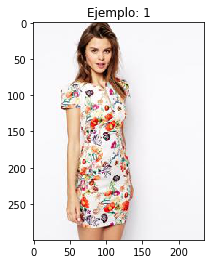

True labels: ['cotton', 'crew_neckline', 'floral', 'mini_length', 'short_sleeve', 'tight']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'floral', 'no_dress', 'short_sleeve']


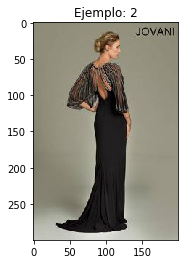

True labels: ['chiffon', 'conventional', 'long_sleeve', 'no_dress', 'no_neckline', 'pleated']
Predicted labels: ['chiffon', 'conventional', 'cotton', 'crew_neckline', 'sleeveless', 'solid']


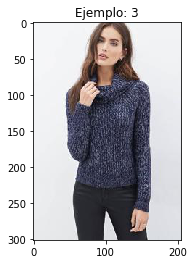

True labels: ['conventional', 'crew_neckline', 'knit', 'long_sleeve', 'no_dress', 'solid']
Predicted labels: ['conventional', 'cotton', 'crew_neckline', 'long_sleeve', 'no_dress', 'v_neckline']


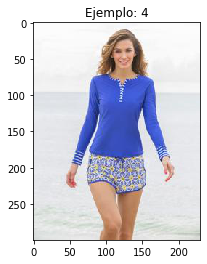

True labels: ['conventional', 'cotton', 'floral', 'no_dress', 'no_neckline', 'sleeveless']
Predicted labels: ['conventional', 'cotton', 'no_dress', 'no_neckline', 'sleeveless', 'solid']


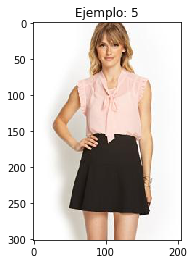

True labels: ['chiffon', 'conventional', 'no_dress', 'sleeveless', 'solid', 'v_neckline']
Predicted labels: ['conventional', 'cotton', 'no_dress', 'no_neckline', 'sleeveless', 'solid']


In [123]:
# Evaluar partición de test
# %cache -r inceptionV3_test_res
%cache inceptionV3_test_res = evaluate('InceptionV3', 6)
y_pred_inceptionV3 = inceptionV3_test_res[0]
results_inceptionV3 = inceptionV3_test_res[1]
# Mostrar resultados
print_results(results_inceptionV3)
# Mostrar ejemplos
display_examples(y_pred_inceptionV3)

In [124]:
%cache resnet50_test_res = evaluate('ResNet50', 6)
y_pred_resnet50 = resnet50_test_res[0]
results_resnet50 = resnet50_test_res[1]

Creating new value for variable 'resnet50_test_res'
./data/anno_fine/test_attr.txt
Found 4000 validated image filenames.
125/125 [==============================] - 61s 492ms/step


In [125]:
%cache vgg16_test_res = evaluate('VGG16', 6)
y_pred_vgg16 = vgg16_test_res[0]
results_vgg16 = vgg16_test_res[1]

Creating new value for variable 'vgg16_test_res'
./data/anno_fine/test_attr.txt
Found 4000 validated image filenames.
125/125 [==============================] - 44s 352ms/step
